In [20]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.preprocessing import StandardScaler

What will try to do is build a multi input neural net, one input for each categorical feature, as for the numerical features, all of them will be fed from a single input:

- First we need to embed the categorical features(represent each one of the unique values of a categorical feature by a vector),
- For that we will be defining an embedding model for each categorical feature(which is an input layer plus an embedding layer),
- As for the other numeric features, we will feed them to Our model like we usually do for any regular deep learning network from that last input layer. So in total will be having number_of_categorical_features +1 models (number_of_categorical_feature embedding model + an identity model).

- Once we define these models, and since we need 1 model at the end, we will concatenate them into a single layer.

In [21]:
data, labels = shap.datasets.adult(display=True)
data.select_dtypes('category').columns

Index(['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Country'],
      dtype='object')

In [22]:
data

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


In [23]:
def prepar_data_set(data_df):
    categoy_features = data_df.select_dtypes('category').columns
    numeric_features = data_df.select_dtypes('number').columns
    for col in categoy_features:
        encoder = LabelEncoder()
        data_df[col] = encoder.fit_transform(data_df[col])
    return data_df, categoy_features, numeric_features

2.1 — As you can see, for each category in our categorical features, we define an input layer which accepts an input of shape 1(as our input will be the value of the category which just a number),

2.2 — We give it a name so we can properly send to it the right data (very practical thing to do, I recommend it).

2.3 — Then we define our embedding layer which is basically a matrix with a number of row and columns.

2.3.1 — The number of rows will be the cardinality of the categorical features(how many unique values),

2.3.2 — The number of columns will be the lent of the vector which will represent those unique values(which are the parameters to be tuned). For this tutorial we choose 200(a very common number to start with).

2.3.2 — Pay attention that we set the layer to Trainable. Since we have initialized it with just random numbers which are of no value to us, we need it to keep updating during the training(back propagation).

2.3.3 — Finally we have to reshape the output to a single 1-D array, which basically will have the shape of the lent of the embedding vector.

So, this is how we will define our number_of_categorical_feature embedding models (in this case 7 categorical feature which mean 7 embedding models).

2.4 — As for our numerical features, will be feeding them as we usually do, from their own Input layer.

In [25]:
def generate_categorical_feature_tf(categorical_features, num_features, data):
    models = []
    inputs = []
    
    for cat in categorical_features:
        vocab_size = data[cat].nunique()
        inpt = tf.keras.layers.Input(
            shape=(1,), name='input_'+'_'.join(cat.split(' ')))
        inputs.append(inpt)
        embed = tf.keras.layers.Embedding(vocab_size, 200,
                                          trainable=True, embeddings_initializer=tf.initializers.random_normal)(inpt)
        embed_rehsaped = tf.keras.layers.Reshape(target_shape=(200,))(embed)
        models.append(embed_rehsaped)
        
    num_input = tf.keras.layers.Input(shape=(len(num_features)),
                                      name='input_number_features')
    inputs.append(num_input)
    models.append(num_input)
    
    merge_models = tf.keras.layers.concatenate(models)
    pre_preds = tf.keras.layers.Dense(1000)(merge_models)
    pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
    pre_preds = tf.keras.layers.Dense(1000)(pre_preds)
    pre_preds = tf.keras.layers.BatchNormalization()(pre_preds)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(pre_preds)
    model_full = tf.keras.models.Model(inputs=inputs,
                                       outputs=pred)
    model_full.compile(loss=tf.keras.losses.binary_crossentropy,
                       metrics=['accuracy'],
                       optimizer='adam')
    return model_full

In [26]:
train, cat_features, num_featture = prepar_data_set(data)

model = generate_categorical_feature_tf(cat_features, num_featture, train)

In [27]:
cat_features

Index(['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Country'],
      dtype='object')

In [28]:
scaler = StandardScaler()
train[num_featture] = scaler.fit_transform(train[num_featture])
input_dict = {
    'input_Workclass': train[cat_features[0]],
    "input_Marital_Status": train[cat_features[1]],
    "input_Occupation": train[cat_features[2]],
    "input_Relationship": train[cat_features[3]],
    "input_Race": train[cat_features[4]],
    "input_Sex": train[cat_features[5]],
    "input_Country": train[cat_features[6]],
    "input_number_features": train[num_featture]
}

model.fit(input_dict, labels*1, epochs=10,
          batch_size=64, class_weight={0: 0.5, 1: 0.5})

Epoch 1/50


2023-04-02 02:57:06.255784: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x4d078940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-02 02:57:06.255831: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2023-04-02 02:57:06.601309: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-02 02:57:09.276335: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-02 02:57:09.682976: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


509/509 [==============================] - 36s 18ms/step - loss: 0.2009 - accuracy: 0.8235
Epoch 2/50
509/509 [==============================] - 4s 8ms/step - loss: 0.1710 - accuracy: 0.8398
Epoch 3/50
509/509 [==============================] - 4s 8ms/step - loss: 0.1683 - accuracy: 0.8415
Epoch 4/50
509/509 [==============================] - 4s 8ms/step - loss: 0.1671 - accuracy: 0.8446
Epoch 5/50
509/509 [==============================] - 4s 8ms/step - loss: 0.1668 - accuracy: 0.8444
Epoch 6/50
509/509 [==============================] - 4s 8ms/step - loss: 0.1670 - accuracy: 0.8439
Epoch 7/50
509/509 [==============================] - 4s 8ms/step - loss: 0.1666 - accuracy: 0.8472
Epoch 8/50
509/509 [==============================] - 4s 8ms/step - loss: 0.1657 - accuracy: 0.8444
Epoch 9/50
509/509 [==============================] - 4s 8ms/step - loss: 0.1663 - accuracy: 0.8453
Epoch 10/50
509/509 [==============================] - 4s 9ms/step - loss: 0.1660 - accuracy: 0.8449
Epoch 11

In [1]:
# load and summarize the dataset
from pandas import read_csv
from sklearn.model_selection import train_test_split

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    data = read_csv(filename, header=None)
    # retrieve numpy array
    dataset = data.values
    # split into input (X) and output (y) variables
    X = dataset[:, :-1]
    y = dataset[:, -1]
    # format all fields as string
    X = X.astype(str)
    # reshape target to be a 2d array
    y = y.reshape((len(y), 1))
    return X, y

In [2]:
# load the dataset
X, y = load_dataset('../data/breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (191, 9) (191, 1)
Test (95, 9) (95, 1)


In [10]:
X

array([["'40-49'", "'premeno'", "'15-19'", ..., "'right'", "'left_up'",
        "'no'"],
       ["'50-59'", "'ge40'", "'15-19'", ..., "'right'", "'central'",
        "'no'"],
       ["'50-59'", "'ge40'", "'35-39'", ..., "'left'", "'left_low'",
        "'no'"],
       ...,
       ["'30-39'", "'premeno'", "'30-34'", ..., "'right'", "'right_up'",
        "'no'"],
       ["'50-59'", "'premeno'", "'15-19'", ..., "'right'", "'left_low'",
        "'no'"],
       ["'50-59'", "'ge40'", "'40-44'", ..., "'left'", "'right_up'",
        "'no'"]], dtype='<U11')

### Ordinal Encode Categorical Data

An ordinal encoding involves mapping each unique label to an integer value. As such, it is sometimes referred to simply as an integer encoding. This type of encoding is really only appropriate if *there is a known relationship between the categories.*

This relationship does exist for some of the variables in the dataset, and ideally, this should be harnessed when preparing the data.

In this case, we will ignore any possible existing ordinal relationship and assume all variables are categorical. It can still be helpful to use an ordinal encoding, at least as a point of reference with other encoding schemes.

In [5]:
# example of ordinal encoding for a neural network
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from keras.models import Sequential
from keras.layers import Dense
 
# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    data = read_csv(filename, header=None)
    # retrieve numpy array
    dataset = data.values
    # split into input (X) and output (y) variables
    X = dataset[:, :-1]
    y = dataset[:,-1]
    # format all fields as string
    X = X.astype(str)
    # reshape target to be a 2d array
    y = y.reshape((len(y), 1))
    return X, y
 
# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [7]:
 # load the dataset
X, y = load_dataset('../data/breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

/home/masoud/anaconda3/envs/mlep-w1-lab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/masoud/anaconda3/envs/mlep-w1-lab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/masoud/anaconda3/envs/mlep-w1-lab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [8]:
X_train_enc

array([[ 3.,  0.,  4., ...,  0.,  3.,  0.],
       [ 1.,  2.,  9., ...,  0.,  3.,  0.],
       [ 3.,  2., 10., ...,  1.,  2.,  1.],
       ...,
       [ 4.,  0.,  1., ...,  1.,  1.,  0.],
       [ 4.,  0.,  7., ...,  1.,  1.,  0.],
       [ 4.,  0.,  8., ...,  0.,  0.,  0.]])

In [11]:
# define the  model
model = Sequential()
model.add(Dense(10, input_dim=X_train_enc.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_enc, y_train_enc, epochs=100, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test_enc, y_test_enc, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

2023-04-02 12:50:24.723035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-02 12:50:25.760752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-04-02 12:50:25.760834: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-02 12:50:25.825629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

Epoch 1/100
12/12 - 2s - loss: 0.9950 - accuracy: 0.4346 - 2s/epoch - 150ms/step
Epoch 2/100
12/12 - 0s - loss: 0.8761 - accuracy: 0.5236 - 26ms/epoch - 2ms/step
Epoch 3/100
12/12 - 0s - loss: 0.7826 - accuracy: 0.5812 - 20ms/epoch - 2ms/step
Epoch 4/100
12/12 - 0s - loss: 0.7196 - accuracy: 0.6073 - 21ms/epoch - 2ms/step
Epoch 5/100
12/12 - 0s - loss: 0.6754 - accuracy: 0.6387 - 23ms/epoch - 2ms/step
Epoch 6/100
12/12 - 0s - loss: 0.6459 - accuracy: 0.6702 - 18ms/epoch - 1ms/step
Epoch 7/100
12/12 - 0s - loss: 0.6298 - accuracy: 0.6702 - 20ms/epoch - 2ms/step
Epoch 8/100
12/12 - 0s - loss: 0.6171 - accuracy: 0.6702 - 20ms/epoch - 2ms/step
Epoch 9/100
12/12 - 0s - loss: 0.6077 - accuracy: 0.6806 - 20ms/epoch - 2ms/step
Epoch 10/100
12/12 - 0s - loss: 0.6008 - accuracy: 0.6859 - 21ms/epoch - 2ms/step
Epoch 11/100
12/12 - 0s - loss: 0.5951 - accuracy: 0.6963 - 20ms/epoch - 2ms/step
Epoch 12/100
12/12 - 0s - loss: 0.5897 - accuracy: 0.6963 - 20ms/epoch - 2ms/step
Epoch 13/100
12/12 - 0s -

### One Hot Encode Categorical Data

A one hot encoding is appropriate for categorical data where no relationship exists between categories.

It involves representing each categorical variable with a binary vector that has one element for each unique label and marking the class label with a 1 and all other elements 0.

For example, if our variable was “color” and the labels were “red,” “green,” and “blue,” we would encode each of these labels as a three-element binary vector as follows:

Red: [1, 0, 0]

Green: [0, 1, 0]

Blue: [0, 0, 1]

Then each label in the dataset would be replaced with a vector (one column becomes three). This is done for all categorical variables so that our nine input variables or columns become 43 in the case of the breast cancer dataset.

In [12]:
# example of one hot encoding for a neural network
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    data = read_csv(filename, header=None)
    # retrieve numpy array
    dataset = data.values
    # split into input (X) and output (y) variables
    X = dataset[:, :-1]
    y = dataset[:,-1]
    # format all fields as string
    X = X.astype(str)
    # reshape target to be a 2d array
    y = y.reshape((len(y), 1))
    return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# load the dataset
X, y = load_dataset('../data/breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

/home/masoud/anaconda3/envs/mlep-w1-lab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/masoud/anaconda3/envs/mlep-w1-lab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/masoud/anaconda3/envs/mlep-w1-lab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [13]:
X_train_enc.shape

(191, 43)

In [15]:
# define the  model
model = Sequential()
model.add(Dense(10, input_dim=X_train_enc.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_enc, y_train_enc, epochs=100, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test_enc, y_test_enc, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/100
12/12 - 1s - loss: 0.7151 - accuracy: 0.5236 - 596ms/epoch - 50ms/step
Epoch 2/100
12/12 - 0s - loss: 0.6764 - accuracy: 0.5969 - 21ms/epoch - 2ms/step
Epoch 3/100
12/12 - 0s - loss: 0.6468 - accuracy: 0.6597 - 25ms/epoch - 2ms/step
Epoch 4/100
12/12 - 0s - loss: 0.6252 - accuracy: 0.6859 - 25ms/epoch - 2ms/step
Epoch 5/100
12/12 - 0s - loss: 0.6049 - accuracy: 0.6963 - 23ms/epoch - 2ms/step
Epoch 6/100
12/12 - 0s - loss: 0.5915 - accuracy: 0.7068 - 24ms/epoch - 2ms/step
Epoch 7/100
12/12 - 0s - loss: 0.5800 - accuracy: 0.7173 - 23ms/epoch - 2ms/step
Epoch 8/100
12/12 - 0s - loss: 0.5716 - accuracy: 0.7277 - 23ms/epoch - 2ms/step
Epoch 9/100
12/12 - 0s - loss: 0.5634 - accuracy: 0.7277 - 22ms/epoch - 2ms/step
Epoch 10/100
12/12 - 0s - loss: 0.5570 - accuracy: 0.7277 - 23ms/epoch - 2ms/step
Epoch 11/100
12/12 - 0s - loss: 0.5509 - accuracy: 0.7382 - 24ms/epoch - 2ms/step
Epoch 12/100
12/12 - 0s - loss: 0.5458 - accuracy: 0.7435 - 24ms/epoch - 2ms/step
Epoch 13/100
12/12 - 0s

Accuracy: 65.26


### Learned Embedding for Categorical Data

A learned embedding, or simply an “embedding,” is a distributed representation for categorical data.

Each category is mapped to a distinct vector, and the properties of the vector are adapted or learned while training a neural network. The vector space provides a projection of the categories, allowing those categories that are close or related to cluster together naturally.

This provides both the benefits of an ordinal relationship by allowing any such relationships to be learned from data, and a one hot encoding in providing a vector representation for each category. Unlike one hot encoding, the input vectors are not sparse (do not have lots of zeros). The downside is that it requires learning as part of the model and the creation of many more input variables (columns).

The technique was originally developed to provide a distributed representation for words, e.g. allowing similar words to have similar vector representations. As such, the technique is often referred to as a word embedding, and in the case of text data, algorithms have been developed to learn a representation independent of a neural network. 

An additional benefit of using an embedding is that the learned vectors that each category is mapped to can be fit in a model that has modest skill, but the vectors can be extracted and used generally as input for the category on a range of different models and applications. That is, they can be learned and reused.


One embedding layer is required for each categorical variable, and the embedding expects the categories to be ordinal encoded, although no relationship between the categories is assumed.

Each embedding also requires the number of dimensions to use for the distributed representation (vector space). It is common in natural language applications to use 50, 100, or 300 dimensions. For our small example, we will fix the number of dimensions at 10, but this is arbitrary; you should experimenter with other values.

First, we can prepare the input data using an ordinal encoding.

The model we will develop will have one separate embedding for each input variable. Therefore, the model will take nine different input datasets. As such, we will split the input variables and ordinal encode (integer encoding) each separately using the LabelEncoder and return a list of separate prepared train and test input datasets.

The prepare_inputs() function, enumerating over each input variable, integer encoding each correctly using best practices, and returning lists of encoded train and test variables (or one-variable datasets) that can be used as input for our model later.

We must construct the model differently in this case because we will have nine input layers, with nine embeddings the outputs of which (the nine different 10-element vectors) need to be concatenated into one long vector before being passed as input to the dense layers.

We can achieve this using the functional Keras API.

First, we can enumerate each variable and construct an input layer and connect it to an embedding layer, and store both layers in lists. We need a reference to all of the input layers when defining the model, and we need a reference to each embedding layer to concentrate them with a merge layer.

In [17]:
# example of learned embedding encoding for a neural network
from numpy import unique
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import concatenate
from keras.utils import plot_model

# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    data = read_csv(filename, header=None)
    # retrieve numpy array
    dataset = data.values
    # split into input (X) and output (y) variables
    X = dataset[:, :-1]
    y = dataset[:,-1]
    # format all fields as string
    X = X.astype(str)
    # reshape target to be a 2d array
    y = y.reshape((len(y), 1))
    return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
    X_train_enc, X_test_enc = list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        le.fit(X_train[:, i])
        # encode
        train_enc = le.transform(X_train[:, i])
        test_enc = le.transform(X_test[:, i])
        # store
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [18]:
# load the dataset
X, y = load_dataset('../data/breast-cancer.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# make output 3d
y_train_enc = y_train_enc.reshape((len(y_train_enc), 1, 1))
y_test_enc = y_test_enc.reshape((len(y_test_enc), 1, 1))

/home/masoud/anaconda3/envs/mlep-w1-lab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/masoud/anaconda3/envs/mlep-w1-lab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/masoud/anaconda3/envs/mlep-w1-lab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [19]:
# prepare each input head
in_layers = list()
em_layers = list()
for i in range(len(X_train_enc)):
    # calculate the number of unique inputs
    n_labels = len(unique(X_train_enc[i]))
    # define input layer
    in_layer = Input(shape=(1,))
    # define embedding layer
    em_layer = Embedding(n_labels, 10)(in_layer)
    # store layers
    in_layers.append(in_layer)
    em_layers.append(em_layer)
# concat all embeddings
merge = concatenate(em_layers)
dense = Dense(10, activation='relu', kernel_initializer='he_normal')(merge)
output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=in_layers, outputs=output)

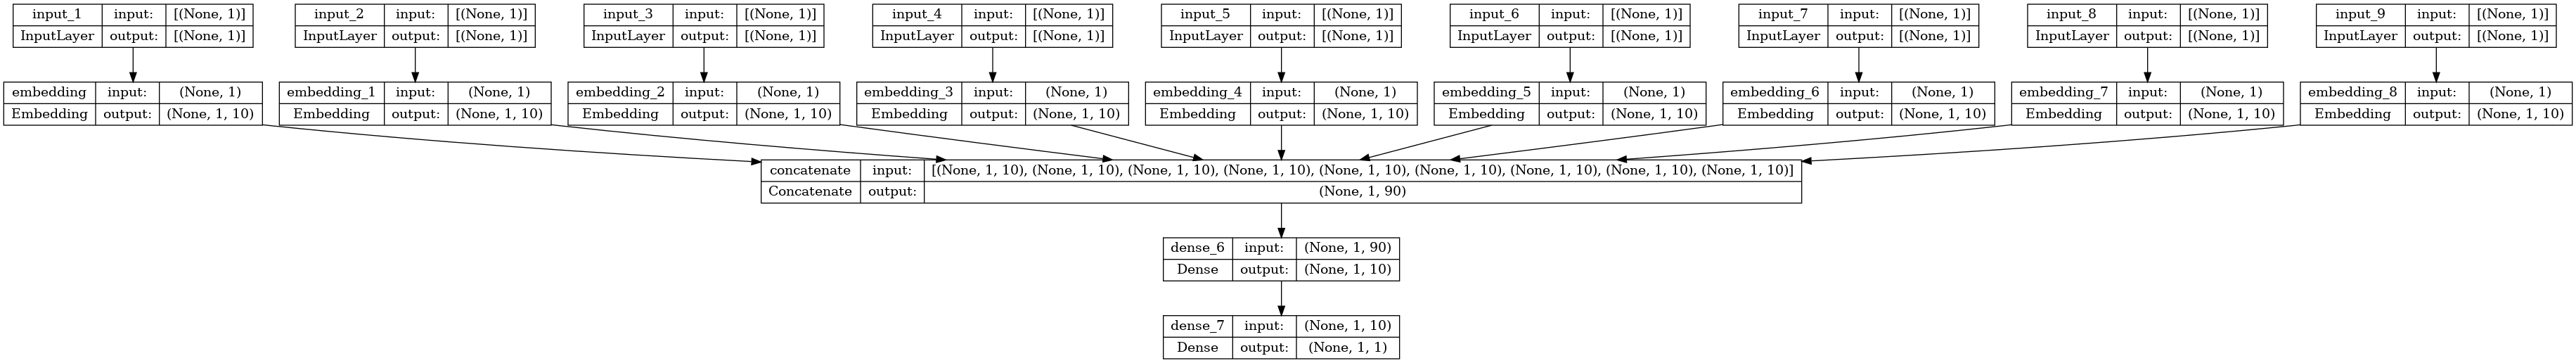

In [20]:
# plot graph
plot_model(model, show_shapes=True)

In [21]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_enc, y_train_enc, epochs=20, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test_enc, y_test_enc, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/20
12/12 - 1s - loss: 0.6843 - accuracy: 0.6911 - 1s/epoch - 125ms/step
Epoch 2/20
12/12 - 0s - loss: 0.6666 - accuracy: 0.7277 - 30ms/epoch - 3ms/step
Epoch 3/20
12/12 - 0s - loss: 0.6497 - accuracy: 0.7277 - 28ms/epoch - 2ms/step
Epoch 4/20
12/12 - 0s - loss: 0.6313 - accuracy: 0.7277 - 29ms/epoch - 2ms/step
Epoch 5/20
12/12 - 0s - loss: 0.6111 - accuracy: 0.7277 - 29ms/epoch - 2ms/step
Epoch 6/20
12/12 - 0s - loss: 0.5900 - accuracy: 0.7277 - 31ms/epoch - 3ms/step
Epoch 7/20
12/12 - 0s - loss: 0.5713 - accuracy: 0.7277 - 27ms/epoch - 2ms/step
Epoch 8/20
12/12 - 0s - loss: 0.5570 - accuracy: 0.7277 - 29ms/epoch - 2ms/step
Epoch 9/20
12/12 - 0s - loss: 0.5437 - accuracy: 0.7277 - 29ms/epoch - 2ms/step
Epoch 10/20
12/12 - 0s - loss: 0.5344 - accuracy: 0.7330 - 25ms/epoch - 2ms/step
Epoch 11/20
12/12 - 0s - loss: 0.5265 - accuracy: 0.7487 - 29ms/epoch - 2ms/step
Epoch 12/20
12/12 - 0s - loss: 0.5187 - accuracy: 0.7696 - 28ms/epoch - 2ms/step
Epoch 13/20
12/12 - 0s - loss: 0.5128